# Crypto currency price history

## Get started

> **Note**: this notebook uses python 3 as kernel

This notebook assumes the data is already downloaded and stored at `../data/raw`

if not, execute the next:

`python ../src/data/get_dataset.py`


## 1. Read data

We will be using, at first instance, the following python modules:
* `Path from pahtlib` to deal with directories/files an its path
* `pandas` to read and process the data
* `pickle` to keep stored the read and processed data as a byte stream to save loading times in specific cases

In [1]:
from pathlib import Path
import pandas as pd
import pickle as pkl

Read the .csv files and store the data as dataframes in a specific dictionary build with this aim.

Moreover, it is implemented using `pickle` a way to save loding times, because when the data is read for the first time it is saved as a .pkl byte stream file, and will be no need to read it all again.

In [2]:
def read_data():
    REL_PATH = Path().glob("../data/raw/cryptocurrencypricehistory/*.csv") # working with .csv files
    
    # two kind of files: datasets and price (classification based on its inner data and structure)
    data = dict() # init data structure
    
    for file in REL_PATH:
        df = pd.read_csv(file)
        filename, kind = Path(file).stem.rsplit("_", 1) # based on the .csv filenames format
        
        df["Crypto"] = pd.Series([filename] * df.shape[0], dtype=pd.StringDtype()) # to identify each record its added a categorical value based on the filename
        data.setdefault(kind, list()).append(df) # data['price'].append(df) if kind == 'price' else data['datasets'].append(df)
        
        pkl.dump(data, open('../data/interim/crypto.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL) # save read data
    
    return data

data = pkl.load(open('../data/interim/crypto.pkl', 'rb')) if Path("../data/interim/crypto.pkl").is_file() else read_data()

In addition, the data is divided in two list stored in a dictionary.

The first one, contains the dataframes related to the `price` files, and the second one keeps the `dataset` ones.

In [3]:
[print("List '{}' contains {} dataframes".format(key, len(data[key]))) for key in data.keys()]

List 'price' contains 17 dataframes
List 'dataset' contains 2 dataframes


[None, None]

## 2. Clean Data
Once the data has been read and stored by classification in our dictionary, we can proceed to get information from it.
### 2.1 Price data

In [4]:
data['price'][0].info() # get first feedback from the data structure
data['price'][0].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        229 non-null    object 
 1   Open        229 non-null    float64
 2   High        229 non-null    float64
 3   Low         229 non-null    float64
 4   Close       229 non-null    float64
 5   Volume      229 non-null    object 
 6   Market Cap  229 non-null    object 
 7   Crypto      229 non-null    string 
dtypes: float64(4), object(3), string(1)
memory usage: 14.4+ KB


,Date,Open,High,Low,Close,Volume,Market Cap,Crypto
0,"Sep 05, 2017",114.74,131.57,108.93,129.42,"8,537,600","756,793,000",bitconnect
1,"Sep 04, 2017",128.26,129.55,110.68,114.13,"30,395,600","845,031,000",bitconnect
2,"Sep 03, 2017",131.71,135.06,125.87,130.99,"5,244,490","866,869,000",bitconnect
3,"Sep 02, 2017",141.11,142.80,128.00,131.33,"5,056,030","926,918,000",bitconnect
4,"Sep 01, 2017",135.66,140.97,133.47,140.97,"7,854,700","890,229,000",bitconnect


Observing, the `price` dataframe structure and its values we conclude there are types not well considered, as we need to reconvert the `object` dtype, but also there some records from the `Market Cap` and `Volumne` columns containing wrong values, as '`-`'.

In this way, we will basically clean the data by:
* Changing `Date` type to datetime, and specifying a generic format
* Drop those records were there are no `Market Cap` neither `Volumne` values
* Parse the `Market Cap` and `Volume` values and change its type to int64

In [5]:
pd.options.mode.chained_assignment = None  # avoid default='warn'

def parse_num(x):
    return x.replace(',','') if type(x) is str else x

def clean(df):
    df.Date = pd.to_datetime(df.Date, format="%b %d, %Y")
    df = df.loc[(df["Market Cap"] != '-') & (df["Volume"] != '-')]
    df.Volume = df.Volume.apply(lambda x: parse_num(x)).astype('int64')
    df["Market Cap"] = df["Market Cap"].apply(lambda x: parse_num(x)).astype('int64')
    return df

data['price'] = list(map(clean, data['price'])) # clean dataframes
data['price'][0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 228
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        229 non-null    datetime64[ns]
 1   Open        229 non-null    float64       
 2   High        229 non-null    float64       
 3   Low         229 non-null    float64       
 4   Close       229 non-null    float64       
 5   Volume      229 non-null    int64         
 6   Market Cap  229 non-null    int64         
 7   Crypto      229 non-null    string        
dtypes: datetime64[ns](1), float64(4), int64(2), string(1)
memory usage: 16.1 KB


Now, you can see how the structure already has its types correctly as well as its values.

### 2.2 Dataset data
We have two datasets, one referring to the bitcoin cyptocurrency and the other to ehtereum.

To clean the data we will change the format and type of the Date values, and we will eliminate the invalid values by filling them in.

Also, we will rename the price column to be able to compare the two datasets

In [6]:
df_bitcoin = data['dataset'][0]
df_bitcoin.info()
df_bitcoin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1584 non-null   object 
 1   btc_market_price                                     1584 non-null   float64
 2   btc_total_bitcoins                                   1584 non-null   float64
 3   btc_market_cap                                       1584 non-null   float64
 4   btc_trade_volume                                     1106 non-null   float64
 5   btc_blocks_size                                      1584 non-null   float64
 6   btc_avg_block_size                                   1584 non-null   float64
 7   btc_n_orphaned_blocks                                1584 non-null   float64
 8   btc_n_transactions_per_block                         1584 non-null  

,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,...,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,Crypto
0,2009-01-03 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000285,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,50.0,0.0,0.0,bitcoin
1,2009-01-05 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin
2,2009-01-07 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin
3,2009-01-09 00:00:00,0.0,750.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,14.0,14.0,15.0,14.0,14.0,700.0,0.0,0.0,bitcoin
4,2009-01-11 00:00:00,0.0,7600.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,106.0,106.0,152.0,106.0,106.0,5300.0,0.0,0.0,bitcoin


In [7]:
df_bitcoin.Date = pd.to_datetime(df_bitcoin.Date, format = "%Y-%m-%d %H:%M:%S")
df_bitcoin = df_bitcoin.rename(columns={'btc_market_price': 'Price'})
df_bitcoin.isna().sum()
df_bitcoin = df_bitcoin.fillna(0)

data['dataset'][0] = df_bitcoin
data['dataset'][0].head()

,Date,Price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,...,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,Crypto
0,2009-01-03,0.0,50.0,0.0,0.0,0.0,0.000285,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,50.0,0.0,0.0,bitcoin
1,2009-01-05,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin
2,2009-01-07,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin
3,2009-01-09,0.0,750.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,14.0,14.0,15.0,14.0,14.0,700.0,0.0,0.0,bitcoin
4,2009-01-11,0.0,7600.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,106.0,106.0,152.0,106.0,106.0,5300.0,0.0,0.0,bitcoin


In [8]:
df_ethereum = data['dataset'][1]
df_ethereum.info()
df_ethereum.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date(UTC)          769 non-null    object 
 1   UnixTimeStamp      769 non-null    int64  
 2   eth_etherprice     769 non-null    float64
 3   eth_tx             769 non-null    int64  
 4   eth_address        769 non-null    int64  
 5   eth_supply         769 non-null    float64
 6   eth_marketcap      769 non-null    float64
 7   eth_hashrate       769 non-null    float64
 8   eth_difficulty     769 non-null    float64
 9   eth_blocks         769 non-null    int64  
 10  eth_uncles         769 non-null    int64  
 11  eth_blocksize      769 non-null    int64  
 12  eth_blocktime      769 non-null    float64
 13  eth_gasprice       769 non-null    int64  
 14  eth_gaslimit       769 non-null    int64  
 15  eth_gasused        769 non-null    int64  
 16  eth_ethersupply    769 non

,Date(UTC),UnixTimeStamp,eth_etherprice,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,eth_ethersupply,eth_chaindatasize,eth_ens_register,Crypto
0,7/30/2015,1438214400,0.0,8893,9205,7.204931e+07,0.0,23.7569,0.121,6912,1299,644,4.46,0,0,0,39316.09375,NaN,NaN,ethereum
1,7/31/2015,1438300800,0.0,0,9361,7.208550e+07,0.0,48.1584,0.603,6863,511,582,12.58,0,0,0,36191.71875,NaN,NaN,ethereum
2,8/1/2015,1438387200,0.0,0,9476,7.211320e+07,0.0,55.2709,0.887,5293,334,575,16.34,0,0,0,27705.93750,NaN,NaN,ethereum
3,8/2/2015,1438473600,0.0,0,9563,7.214143e+07,0.0,64.1779,1.020,5358,394,581,16.12,0,0,0,28223.43750,NaN,NaN,ethereum
4,8/3/2015,1438560000,0.0,0,9639,7.216940e+07,0.0,69.8559,1.126,5280,443,587,16.37,0,0,0,27976.71875,NaN,NaN,ethereum


In [9]:
df_ethereum = df_ethereum.rename(columns={'Date(UTC)': 'Date'})
df_ethereum = df_ethereum.rename(columns={'eth_etherprice': 'Price'})
df_ethereum.Date = pd.to_datetime(df_ethereum.Date, format = "%m/%d/%Y")
df_ethereum.isna().sum()
df_ethereum = df_ethereum.drop('eth_chaindatasize', 1)
df_ethereum = df_ethereum.fillna(0)

data['dataset'][1] = df_ethereum
data['dataset'][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              769 non-null    datetime64[ns]
 1   UnixTimeStamp     769 non-null    int64         
 2   Price             769 non-null    float64       
 3   eth_tx            769 non-null    int64         
 4   eth_address       769 non-null    int64         
 5   eth_supply        769 non-null    float64       
 6   eth_marketcap     769 non-null    float64       
 7   eth_hashrate      769 non-null    float64       
 8   eth_difficulty    769 non-null    float64       
 9   eth_blocks        769 non-null    int64         
 10  eth_uncles        769 non-null    int64         
 11  eth_blocksize     769 non-null    int64         
 12  eth_blocktime     769 non-null    float64       
 13  eth_gasprice      769 non-null    int64         
 14  eth_gaslimit      769 non-

When we have the data cleaned, we proceed to save them using the `pickle` module.

In [17]:
pkl.dump(data, open('../data/processed/crypto.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL) # save cleaned data

## 3 Report
As we cleaned the data just by observing the dataframes format, then we want to get deeper running a complete report.

Better way to get more information and assure the data is all cleaned.

In [10]:
from pandas_profiling import ProfileReport

REP_PATH = "../reports/"

def report(df, output, sub_dir=""):
    profile = ProfileReport(df, title="Pandas Profiling Report {}".format(output), explorative=False, progress_bar=False)
    profile.to_widgets()
    
    directory = Path(REP_PATH + sub_dir).joinpath(output)
    directory.mkdir(parents=True, exist_ok=True)
    profile.to_file(directory.joinpath(output + ".html"))
    profile.to_file(directory.joinpath(output + ".json"))

> **Note**: The next code cell will execute the generating reports, be carefull as the pc may need high computation resources!!

In [ ]:
[report(df, df['Crypto'][0], "price") for df in data['price']]

In [ ]:
[report(df, df['Crypto'][0], "dataset") for df in data['dataset']]

The reports confirm that our structure is correct and there are no missing values.

## 4. Visualization
Finally, we will visualize the data using the following modules

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
dff = pd.concat(data['price'], axis=0) # as the tables have the same format and relates to the same info

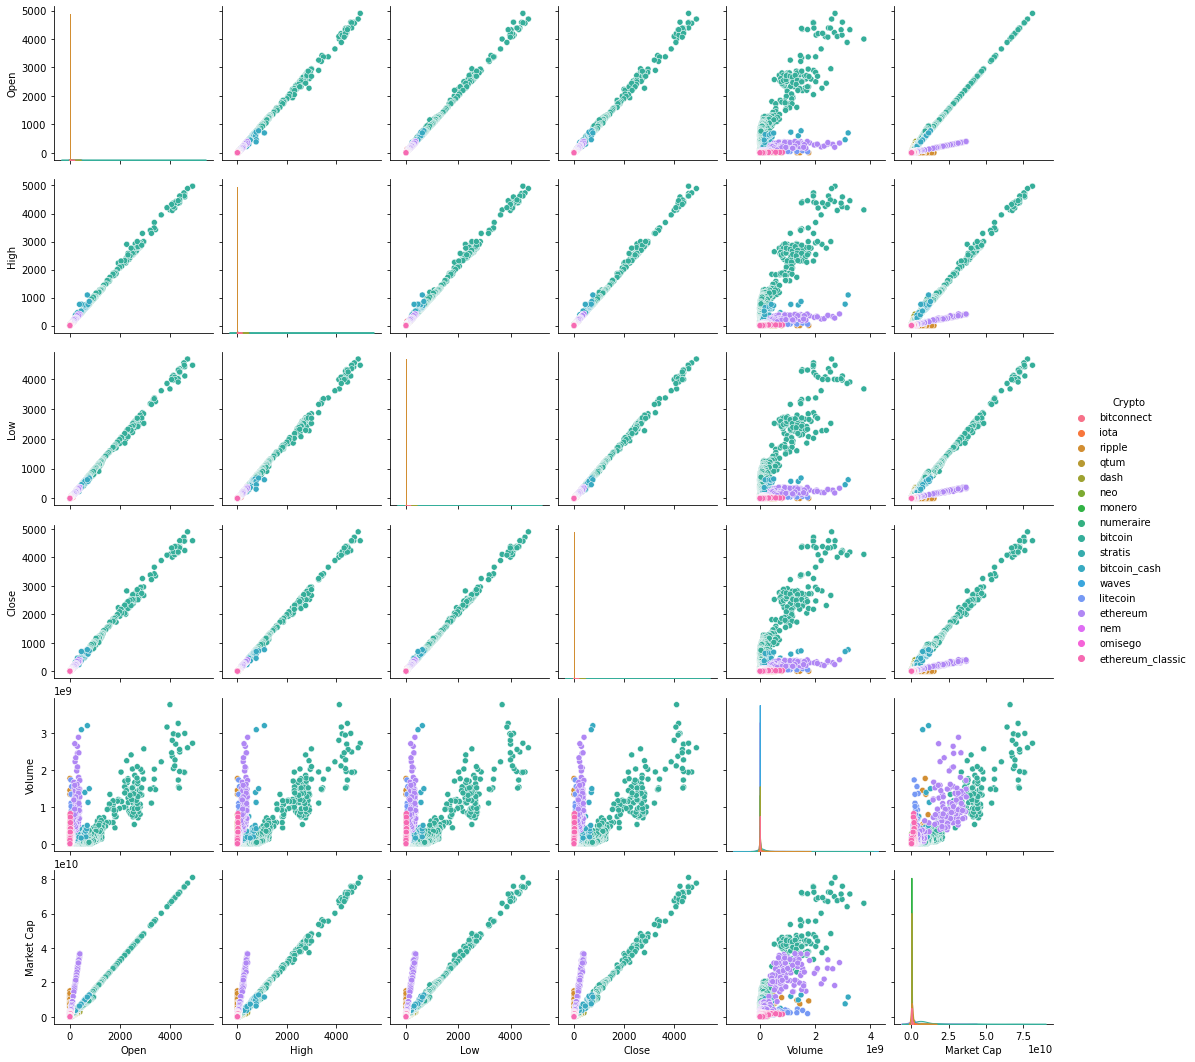

In [13]:
sns_plot = sns.pairplot(dff, hue="Crypto")
sns_plot.savefig(REP_PATH + "figures/" + "crypto.png")

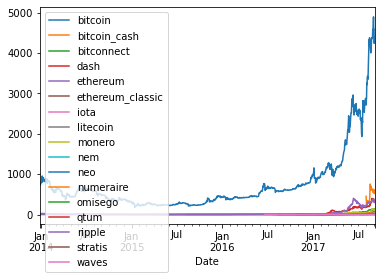

In [14]:
fig, ax = plt.subplots()
for key, grp in dff.groupby(['Crypto']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='Close', label=key)

ax.figure.savefig(REP_PATH + "figures/" + "crypto2.png")

In [15]:
dff = pd.concat(list(map(lambda df: df[['Date', 'Price', 'Crypto']], data['dataset'])), axis=0)
dff.info()
dff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2353 entries, 0 to 768
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2353 non-null   datetime64[ns]
 1   Price   2353 non-null   float64       
 2   Crypto  2353 non-null   string        
dtypes: datetime64[ns](1), float64(1), string(1)
memory usage: 73.5 KB


,Date,Price,Crypto
0,2009-01-03,0.0,bitcoin
1,2009-01-05,0.0,bitcoin
2,2009-01-07,0.0,bitcoin
3,2009-01-09,0.0,bitcoin
4,2009-01-11,0.0,bitcoin


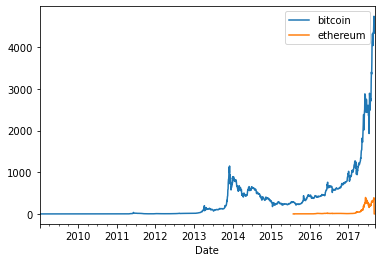

In [16]:
fig, ax = plt.subplots()
for key, grp in dff.groupby(['Crypto']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='Price', label=key) # relate Dataset Prices over Date

ax.figure.savefig(REP_PATH + "figures/" + "price_comparison_btc_eth.png")